In [1]:
%run utils.py

In [2]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [95]:
setup_rucio_and_proxy(upload.data[-1])
import rucio.client
import awkward as ak
import fsspec
from coffea.nanoevents.methods import vector
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import dask
from dask import delayed
from dask.distributed import futures_of
import numpy as np
ak.behavior.update(vector.behavior)

In [4]:
rucio_client = rucio.client.Client()

In [5]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp.data17_13TeV.periodK.grp17_v01_p4309_v3_output.parquet"))

In [7]:
len(files)

465

In [9]:
url = get_signed_url(rucio_client, "user.nihartma", files[0]["name"])

In [77]:
def get_m2mu(url, row_groups=None):
    ak.behavior.update(vector.behavior)
    with fsspec.open(url, cache_type="none") as f:
        events = ak.from_parquet(f, lazy=True, row_groups=row_groups)
        p4 = ak.zip({k: events.Muons[k] for k in ["pt", "eta", "phi"]}, with_name="PtEtaPhiMLorentzVector")
        p4["mass"] = 105.6583715
        mu1, mu2 = ak.unzip(ak.combinations(p4, 2))
        return ak.to_numpy(ak.flatten((mu1 + mu2).mass))

In [55]:
%%time
m2mu = get_m2mu(url)

CPU times: user 4.03 s, sys: 162 ms, total: 4.19 s
Wall time: 14.6 s


/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:160: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [57]:
%%time
m2mu_0 = get_m2mu(url, row_groups=0)

CPU times: user 150 ms, sys: 12.4 ms, total: 162 ms
Wall time: 539 ms


In [49]:
def get_num_row_groups(url):
    with fsspec.open(url, cache_type="none") as f:
        return pq.ParquetFile(f).num_row_groups

In [52]:
%%time
get_num_row_groups(url)

CPU times: user 54.1 ms, sys: 10 ms, total: 64.1 ms
Wall time: 235 ms


46

In [70]:
from dask_gateway import GatewayCluster, Gateway
cluster = GatewayCluster(
    worker_cores=1,
    worker_memory=3.5,
    image="eu.gcr.io/gke-dev-311213/jupyter-physlite:20210622"
)

In [121]:
cluster

In [72]:
client = cluster.get_client()

In [116]:
#client.restart()

In [107]:
cluster.scale(160)

In [84]:
def get_signed_url_worker(proxy_data, scope, name, rucio_account="nihartma"):
    import rucio.client
    setup_rucio_and_proxy(proxy_data, rucio_account=rucio_account, proxy_path="x509")
    rucio_client = rucio.client.Client()
    return get_signed_url(rucio_client, scope, name)

In [114]:
tasks = []
for file in files:
    d_url = delayed(get_signed_url_worker)(upload.data[-1], file["scope"], file["name"])
    tasks.append(delayed(get_m2mu)(d_url))

In [115]:
m2mu_list = dask.persist(*tasks)

In [117]:
m2mu = np.concatenate(dask.compute(*m2mu_list))

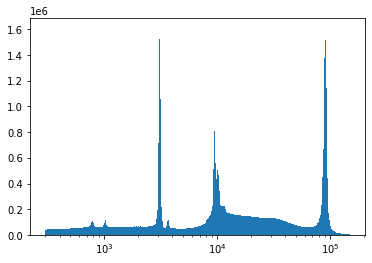

In [119]:
plt.hist(m2mu, bins=np.geomspace(300, 150000, 500))
plt.xscale("log")